In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots
import virtual_sensors as vs
import pandas as pd
import cvxpy as cp

In [2]:
# print settings
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

## Load data

In [3]:
# Error correction
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("data/masters_data2/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("data/masters_data2/step_sensor.csv", delimiter=",")


## Create data frames
The two dataframes aare merged and interpolated to a constant sampling time 1ms.

In [4]:
# sensor data
sensor_column_names = ['Time', 'Encoder 1','Encoder 2','Torque 1', 'Torque 2']
sensor_df = pd.DataFrame(data=sensor_data_step, columns=sensor_column_names)
sensor_df['Time'] = pd.to_timedelta(sensor_df['Time'], unit='s')

# motor data
motor_columns_names = ['Time', 'Motor 1 setpoint ', 'Motor 1', 'Motor 2 setpoint', 'Motor 2']
motor_df = pd.DataFrame(data=motor_data_step, columns=motor_columns_names)
motor_df['Time'] = pd.to_timedelta(motor_df['Time'], unit='s')

# initialize estimates
motor_df['Motor 1 estimate'] = None
motor_df['Motor 2 estimate'] = None


## Construct state-space Model

In [5]:
# get sampling time
dt = float(sensor_df['Time'].diff().dropna().mean().total_seconds())
dt2 = float(motor_df['Time'].diff().dropna().mean().total_seconds())
print(dt, dt2)

inertias, stiffs, damps, damps_ext, ratios = vs.new_parameters()
A, B, C, D = vs.state_space_matrices(inertias, stiffs, damps, damps_ext, ratios, full_B=False, gear_B=False)
sys = vs.ContinuousSystem(A,B,C,D)
sysd = vs.c2d(sys,dt)


0.000996 0.001016


## Construct the Optimization Problem

In [6]:
############################################################
BATCH_SIZE = 400
############################################################

n_states, n_inputs, n_outputs = sysd.get_dims()

class Parameters:
    '''A parameter class for storing parameter values used to solve the cvx problem'''
    def __init__(self,y,x0,O,Gamma,D2,lam,eps):
        self.y = y
        self.x0 = x0
        self.O = O
        self.Gamma = Gamma
        self.D2 = D2
        self.lam = lam
        self.eps = eps

class Variables:
    '''A cvx cariable class for defining optimization variables'''
    def __init__(self,u,zeta,zeta_ast):
        self.u = u
        self.zeta = zeta
        self.zeta_ast = zeta_ast

#calculate parameters
O, Gamma = sysd.dataeq(BATCH_SIZE)
D2 = vs.second_difference_matrix(BATCH_SIZE, n_inputs)
x0 = np.zeros((n_states,1))
y = np.zeros((n_outputs*BATCH_SIZE,1))
lam = 0.01
eps = 0.01
pars = Parameters(y,x0,O,Gamma,D2,lam,eps)

# define variables
u = cp.Variable((n_inputs*BATCH_SIZE,1))
zeta = cp.Variable((BATCH_SIZE*n_outputs,1))
zeta_ast = cp.Variable((BATCH_SIZE*n_outputs,1))
vars = Variables(u,zeta,zeta_ast)

#construct the virtual sensor
virtual_sensor = vs.VirtualSensor(vars, pars, method='svr')


## Solve batch problems

In [7]:
DATA_SIZE = len(sensor_df)
for start in range(0, DATA_SIZE - DATA_SIZE % BATCH_SIZE, BATCH_SIZE):
    end = start + BATCH_SIZE
    batch_df = sensor_df.iloc[start:end]
    df_y = batch_df[['Encoder 1','Encoder 2','Torque 1']]

    t = batch_df['Time'].dt.total_seconds().to_numpy()
    y = np.array(df_y).flatten().reshape(-1,1) #reshape from (n,) to (n,1)

    # update y
    virtual_sensor.pars.y = y
    virtual_sensor.update_problem()

    #solve the problem
    virtual_sensor.solve()
    uhat = np.array(virtual_sensor.vars.u.value).reshape(-1,2)

    # store result in df
    motor_df.iloc[start:end, motor_df.columns.get_loc('Motor 1 estimate')] = uhat[:, 0]
    motor_df.iloc[start:end, motor_df.columns.get_loc('Motor 2 estimate')] = uhat[:, 1]


prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 
prob solved 


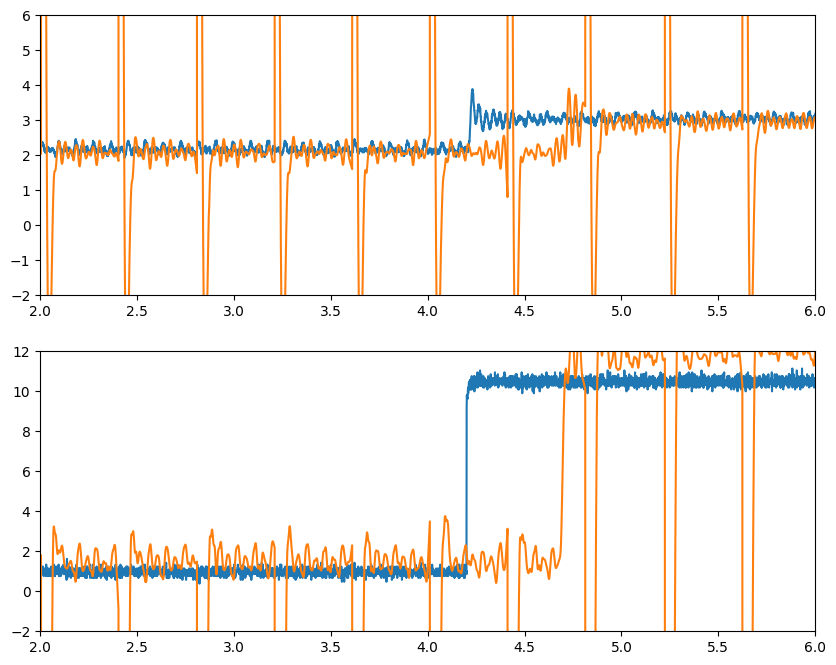

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 1'])
axs[0].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 1 estimate'])
axs[0].set_ylim(-2,6)
axs[0].set_xlim(2,6)

axs[1].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 2'])
axs[1].plot(motor_df['Time'].dt.total_seconds().to_numpy(), motor_df['Motor 2 estimate'])
axs[1].set_ylim(-2,12)
axs[1].set_xlim(2,6)

plt.show()